# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID v2.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers
- ``sample injection order.xlsx`` : File mapping the runs to the batch they were run in.

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

Output plots generated by running this notebook:

- `titer_cv.png`: image of all targets with their isoprenol production and %CV plotted
- `crispri_proteomics.png`: For several proteins, the distribution of all measurements in the library, the control strain, and the CRISPRi target strain
- `crispri_high_producers.png`: The above figure, but for the 20 highest producing targets used for selection.
- `target_filter_results.png`: For each CRISPRi target, a plot of their isoprenol titer and various measures of CRISPRi efficacy showing how CRISPRi filters remove specific targets.

## 1. Setup

### 1.1 Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

Define function for identifying if tests pass throughout the workbook: 

Test: sample test passed


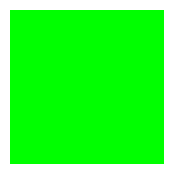

In [2]:
def display_test_passage(condition, test_name):
    color_image = np.zeros((1,1,3))
    if condition: #green if true
        color_index = 1
        test_string = f'Test: {test_name} passed'
    else: #red if false
        color_index = 0
        test_string = f'Test: {test_name} failed'

    color_image[:, :, color_index] = 1
    plt.figure(figsize = (2,2))
    plt.imshow(color_image)
    plt.axis('off')
    print(test_string)
display_test_passage('a' == 'a', 'sample test')

### 1.2 User parameters

In [3]:
user_params = {
    'output_dir'  : './dcas9_analysis',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/sample injection order.xlsx',
    'n_instances_double': 30,
    'n_instances_triple': 30
}

### 1.3 Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [4]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [68]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [6]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

  0%|          | 0/1182675 [00:00<?, ?it/s]

There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [7]:
df['Protocol'].unique()

array(['Biolector', 'GC-FID', 'Global Proteomics'], dtype=object)

## 2. Preprocess and inspect data

### 2.1 Useful functions - preprocessing

In [8]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

### 2.2 Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [9]:
df['Protocol']=='Biolector'

0           True
1           True
2           True
3           True
4           True
           ...  
1182670    False
1182671    False
1182672    False
1182673    False
1182674    False
Name: Protocol, Length: 1182675, dtype: bool

In [96]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [97]:
df2.shape

(1033545, 15)

Let's just keep the basic data types:

In [98]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [99]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(420,
 array(['BL1A2_IY1586', 'BL1A3_IY1587', 'BL1A4_IY1588', 'BL1A5_IY1589',
        'BL1A6_IY1590', 'BL1A7_IY1591', 'BL1A8_IY1592', 'BL1B2_IY1586',
        'BL1B3_IY1587', 'BL1B4_IY1588', 'BL1B5_IY1589', 'BL1B6_IY1590',
        'BL1B7_IY1591', 'BL1B8_IY1592', 'BL1C2_IY1586', 'BL1C3_IY1587',
        'BL1C4_IY1588', 'BL1C5_IY1589', 'BL1C6_IY1590', 'BL1C7_IY1591',
        'BL1C8_IY1592', 'BL1D1_IY1593', 'BL1D2_IY1594', 'BL1D3_IY1595',
        'BL1D4_IY1596', 'BL1D5_IY1597', 'BL1D6_IY1452_pIY1081',
        '**BL1D7_IY1655', '**BL1D8_IY1656', '**BL1E1_IY1593',
        '**BL1E2_IY1594', '**BL1E3_IY1595', 'BL1E4_IY1596', 'BL1E5_IY1597',
        'BL1E6_IY1452_pIY1081', 'BL1E7_IY1655', 'BL1E8_IY1656',
        'BL1F1_IY1593', 'BL1F2_IY1594', 'BL1F3_IY1595', 'BL1F4_IY1596',
        'BL1F5_IY1597', 'BL1F6_IY1452_pIY1081', 'BL1F7_IY1655',
        'BL1F8_IY1656', 'BL2A2_IY1452_pIY1079', 'BL2A3_IY1452_pIY1080',
        'BL2A4_IY1657', 'BL2A5_IY1658', 'BL2A6_IY1659', 'BL2A7_IY1660',
        'BL2A8_I

In [100]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(420,
 array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
        'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
        'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
        'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
        'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
        'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
        'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
        'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
        'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
        'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
        'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
        'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
        'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
        'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
        'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
        'PP_0338-R1', 

In [101]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

In [102]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [103]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

### 2.2 Add strain name to dataframe using prebuilt function.

In [104]:
df2["Strain"] = create_strain_names(df2)
print(df2.shape)

(1033545, 7)


### 2.3 Bring out Uniprot names

In [105]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)
get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'
print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


In [106]:
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590


In [107]:
print(df2.shape)

(1033545, 7)


### 2.4 Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [108]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [109]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

#### 2.4.1 Protein-gene mapping sanity check
Need to check: is there a 1 to 1 correspondence between target genes and uniprot IDs?

There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [110]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets show up multiple times in the uniprot list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times in the target list')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets show up multiple times in the uniprot list:
CRISPRi target gene
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: count, dtype: int64
These Uniprot IDs show up multiple times in the target list
UNIPROT ID
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: count, dtype: int64


In [111]:
df2[df2['Formal Type'] == 'Q99ZW2']

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
386094,Control-R1,BL1A1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,23396190.60,NT
386095,Control-R2,BL1B1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,24489896.20,NT
386096,Control-R3,BL1C1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,25059083.87,NT
386097,Control-R4,BL2A1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,16135133.47,NT
386098,Control-R5,BL2B1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,25734552.30,NT
...,...,...,...,...,...,...,...
1181809,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,469187.37,IY2022
1181810,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,0.00,IY2022
1181811,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,238334.18,IY2019
1181812,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,296369.78,IY2019


In [112]:
ProtMapping_df

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607,Q88MG4
1,IY1452_pIY1080,PP_1607,Q88MG4
2,IY1452_pIY1081,PP_1607,Q88MG4
3,IY1452b_pIY1081,PP_1607,Q88MG4
4,IY1452c_pIY1081,PP_1607,Q88MG4
...,...,...,...
134,IY2226,PP_4186,Q88FB2
135,IY2237,PP_1023,Q88P30
136,IY2238,PP_5128,Q88CQ2
137,IY2239,PP_2095,Q88L40


In [113]:
df_cas = df2[df2['Formal Type'] == 'Q99ZW2'].copy()

In [114]:
df_cas

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
386094,Control-R1,BL1A1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,23396190.60,NT
386095,Control-R2,BL1B1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,24489896.20,NT
386096,Control-R3,BL1C1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,25059083.87,NT
386097,Control-R4,BL2A1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,16135133.47,NT
386098,Control-R5,BL2B1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,25734552.30,NT
...,...,...,...,...,...,...,...
1181809,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,469187.37,IY2022
1181810,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,0.00,IY2022
1181811,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,238334.18,IY2019
1181812,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,296369.78,IY2019


### 2.5 Drop non-target proteins

In [115]:
dcas9_uniprot = 'Q99ZW2'

In [116]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
targets_in_mapping.append(dcas9_uniprot)
df2 = df2.drop(
                    index=df2[(~df2['Formal Type'].isin(targets_in_mapping)) &
                                  (df2['Protocol']=='Global Proteomics')].index)
print(df2.shape)

(42537, 7)


In [117]:
df2[df2['Formal Type'] == 'Q99ZW2']

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
386094,Control-R1,BL1A1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,23396190.60,NT
386095,Control-R2,BL1B1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,24489896.20,NT
386096,Control-R3,BL1C1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,25059083.87,NT
386097,Control-R4,BL2A1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,16135133.47,NT
386098,Control-R5,BL2B1_NT,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,25734552.30,NT
...,...,...,...,...,...,...,...
1181809,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,469187.37,IY2022
1181810,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,0.00,IY2022
1181811,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,238334.18,IY2019
1181812,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q99ZW2,CRISPR-associated endonuclease Cas9/Csn1,296369.78,IY2019


In [118]:
len(targets_in_mapping)

123

### 2.6 Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [119]:
ProtMapping_df

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607,Q88MG4
1,IY1452_pIY1080,PP_1607,Q88MG4
2,IY1452_pIY1081,PP_1607,Q88MG4
3,IY1452b_pIY1081,PP_1607,Q88MG4
4,IY1452c_pIY1081,PP_1607,Q88MG4
...,...,...,...
134,IY2226,PP_4186,Q88FB2
135,IY2237,PP_1023,Q88P30
136,IY2238,PP_5128,Q88CQ2
137,IY2239,PP_2095,Q88L40


In [120]:
uniprot_to_pp = {}
for index in ProtMapping_df.index:
    uniprot_to_pp[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]
uniprot_to_pp[dcas9_uniprot] = 'dCas9'

Do the translation:

In [121]:
proteomics_ind = df2['Protocol']=='Global Proteomics'
df2.loc[proteomics_ind,'Formal Type'] = df2.loc[proteomics_ind,'Formal Type'].apply(lambda x: uniprot_to_pp[x])

### 2.7 Add Target Gene
Add column with a target gene for each strain.

In [122]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

To get target gene:
 Input string: PP_4549-R1, output: PP_4549


In [123]:
df2['Target'] = df2['Line Name'].apply(get_target_gene)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,PP_4549
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,PP_4550
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,PP_0368
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,PP_2136
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,PP_0774


### 2.8 Normalize based on batch

Proteomics for different strains were run in 3 separate batches, and there was batch-to-batch variation in the detector efficiency. There were control strains ran in each batch. Thus, we normalize each strain to the control strains in each batch.  
- Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
- Pull out controls from each batch
- Get rid of proteins missing from controls
- Normalize each run by control mean
- Compare the distributions of normalized and unnormalized proteins

#### 2.8.1 Assign batches to measurements

Import order of runs.

In [124]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()

,Sample Name in order injected,Batch number
0,Control-R1,1
1,Control-R2,1
2,Control-R3,1
3,Control-R4,1
4,Control-R5,1


Make a sample->batch dictionary


In [125]:
batch_dict = dict(df_order.values)

Check that sample names match between EDD and spreadsheet

Test: Run order names match EDD names passed


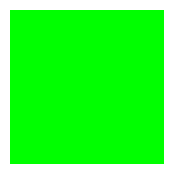

In [126]:
unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
display_test_passage(unique_sample_names_df2 == unique_sample_names_order, 'Run order names match EDD names')

#### 2.8.2 Identify controls

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [127]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)

Add experimental batch to dataframe.

In [128]:
find_batch = lambda x: batch_dict[x]
df2['Batch'] = df2['Line Name'].apply(find_batch)

In [129]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,Batch
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.96040,IY1586,PP_4549,False,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.39750,IY1587,PP_4550,False,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.57140,IY1588,PP_0368,False,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.50970,IY1589,PP_2136,False,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.15880,IY1590,PP_0774,False,1
...,...,...,...,...,...,...,...,...,...,...
1182670,PP_5419-R2,BL4E2_IY2020,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,370.25140,IY2020,PP_5419,False,2
1182671,PP_5419-R3,BL4F2_IY2020,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,412.20373,IY2020,PP_5419,False,2
1182672,PP_5420-R1,BL10A4_IY2019,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,127.37190,IY2019,PP_5420,False,3
1182673,PP_5420-R2,BL10B4_IY2019,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,138.57240,IY2019,PP_5420,False,3


Print the batch for each control - they aren't uniformly distributed.

In [130]:
for ii in range(1,4):
    print(f'Controls in batch {ii}: {df2[(df2["Batch"] == ii) & (df2["Control"])]["Line Name"].unique()}')

Controls in batch 1: ['Control-R1' 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5'
 'Control-R6' 'Control-R7']
Controls in batch 2: ['Control-R8' 'Control-R9' 'Control-R10' 'Control-R11' 'Control-R12'
 'Control-R13' 'Control-R14']
Controls in batch 3: ['Control-R15' 'Control-R16' 'Control-R17' 'Control-R18']


#### 2.8.3 Drop proteins with missing controls
Some proteins have missing measurements in one or more batches, so we can't normalize them.

Check how many different analytes are measured in controls.

In [131]:
print(f'There are {len(df2.loc[df2["Control"], "Measurement Type"].unique())} unique analytes in the control dataframe')

There are 97 unique analytes in the control dataframe


Create pivot table based on batch number. 

In [132]:
control_batch_pivot = pd.pivot_table(df2[df2['Control']], values = 'Value', columns = 'Batch', index = 'Formal Type', aggfunc = np.mean)
control_batch_pivot

Batch,1,2,3
Formal Type,,,
PP_0001,5.382129e+06,3.827842e+06,2.740936e+06
PP_0103,NaN,NaN,1.723723e+04
PP_0168,9.470668e+06,1.091311e+07,5.121947e+06
PP_0225,NaN,6.933567e+03,4.309307e+03
PP_0226,2.374870e+05,2.952860e+05,1.104318e+05
...,...,...,...
PP_5416,7.956082e+06,9.817154e+06,6.652987e+06
PP_5417,3.074205e+07,2.764930e+07,1.941464e+07
PP_5419,1.362560e+06,1.172966e+06,9.349212e+05


Check for NaN measurements in control runs. 

In [133]:
print(f'There are: {sum(control_batch_pivot.isna())} NaNs in measurement pivot table')

There are: 6 NaNs in measurement pivot table


In [134]:
any_measurement_missing = np.where(np.any(control_batch_pivot.isna(), 1))
control_batch_pivot.iloc[any_measurement_missing][:]

Batch,1,2,3
Formal Type,,,
PP_0103,NaN,NaN,17237.2300
PP_0225,NaN,6933.567143,4309.3075
PP_0548,NaN,NaN,4309.3075
PP_4650,16068.194286,13867.134286,NaN


In [135]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,Batch
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.96040,IY1586,PP_4549,False,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.39750,IY1587,PP_4550,False,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.57140,IY1588,PP_0368,False,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.50970,IY1589,PP_2136,False,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.15880,IY1590,PP_0774,False,1
...,...,...,...,...,...,...,...,...,...,...
1182670,PP_5419-R2,BL4E2_IY2020,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,370.25140,IY2020,PP_5419,False,2
1182671,PP_5419-R3,BL4F2_IY2020,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,412.20373,IY2020,PP_5419,False,2
1182672,PP_5420-R1,BL10A4_IY2019,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,127.37190,IY2019,PP_5420,False,3
1182673,PP_5420-R2,BL10B4_IY2019,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,138.57240,IY2019,PP_5420,False,3


Get measurement types that have all their control values. 

In [136]:
control_batch_pivot = control_batch_pivot.dropna() 
list_of_control_type = control_batch_pivot.index.values.tolist()
check_norm_exist = lambda x: 1 if x in list_of_control_type else 0
df2['can_normalize'] = df2['Formal Type'].apply(check_norm_exist)
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,Batch,can_normalize
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.96040,IY1586,PP_4549,False,1,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.39750,IY1587,PP_4550,False,1,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.57140,IY1588,PP_0368,False,1,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.50970,IY1589,PP_2136,False,1,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.15880,IY1590,PP_0774,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1182670,PP_5419-R2,BL4E2_IY2020,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,370.25140,IY2020,PP_5419,False,2,1
1182671,PP_5419-R3,BL4F2_IY2020,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,412.20373,IY2020,PP_5419,False,2,1
1182672,PP_5420-R1,BL10A4_IY2019,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,127.37190,IY2019,PP_5420,False,3,1
1182673,PP_5420-R2,BL10B4_IY2019,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,138.57240,IY2019,PP_5420,False,3,1


Drop measurements that can't be normalized. 

In [137]:
df2 = df2[df2['can_normalize'] == 1]
df2.shape

(41565, 11)

#### 2.8.4. Normalize runs by batch

Need to divide each measurement the correct batch control mean. Create column for holding the control mean and fill it in with lambda function.

In [138]:
df2['control_mean'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in range(1,4):
    add_correct_normalization_value = lambda x: control_batch_pivot[ii][x]
    current_batch_idx = df2['Batch'] == ii
    df2.loc[current_batch_idx, 'control_mean'] = df2[current_batch_idx]['Formal Type'].apply(add_correct_normalization_value)

/tmp/ipykernel_17591/2174918619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['control_mean'] = np.nan


Add column to dataframe and fill it with normalized values. Don't normalize isoprenol since it was not affected by batch variation. Isoprenol was measured using GC, not mass spec.

In [139]:
df2['norm_value'] = np.nan
index_to_normalize = df2['Protocol'] == 'Global Proteomics'
index_not_normalized = df2['Protocol'] != 'Global Proteomics'
df2.loc[index_to_normalize, 'norm_value'] = df2.loc[index_to_normalize, 'Value']/df2.loc[index_to_normalize, 'control_mean']
df2.loc[index_not_normalized, 'norm_value'] = df2.loc[index_not_normalized, 'Value']
df2.head()

/tmp/ipykernel_17591/1421221842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['norm_value'] = np.nan


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Target,Control,Batch,can_normalize,control_mean,norm_value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,PP_4549,False,1,1,205.567203,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,PP_4550,False,1,1,205.567203,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,PP_0368,False,1,1,205.567203,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,PP_2136,False,1,1,205.567203,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,PP_0774,False,1,1,205.567203,215.1588


### 2.9 Visualize normalization effects

#### 2.9.1 Functions for visualizing batch effects

Functions generate swarm plots grouped by batch with individual datapoints represented by blue dots and the mean of each group down with a red dash.

In [140]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch', y = to_plot, alpha = 0.5)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch'] == batch_num)][to_plot]) for batch_num in batches]
                    
    [ax.scatter(i, mean_vals[i], color = 'red', marker = '_', s = 100, zorder = 10) for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))
    return fig

This function plots the distribution of differences between different batches of data for all proteins in the dataset.

In [141]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between batches.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax       

#### 2.9.2 Swarmplots of controls
Plot the measurements of individual controls (blue dots) and the batch mean of the control (red line) between batches using a swarm plot. 

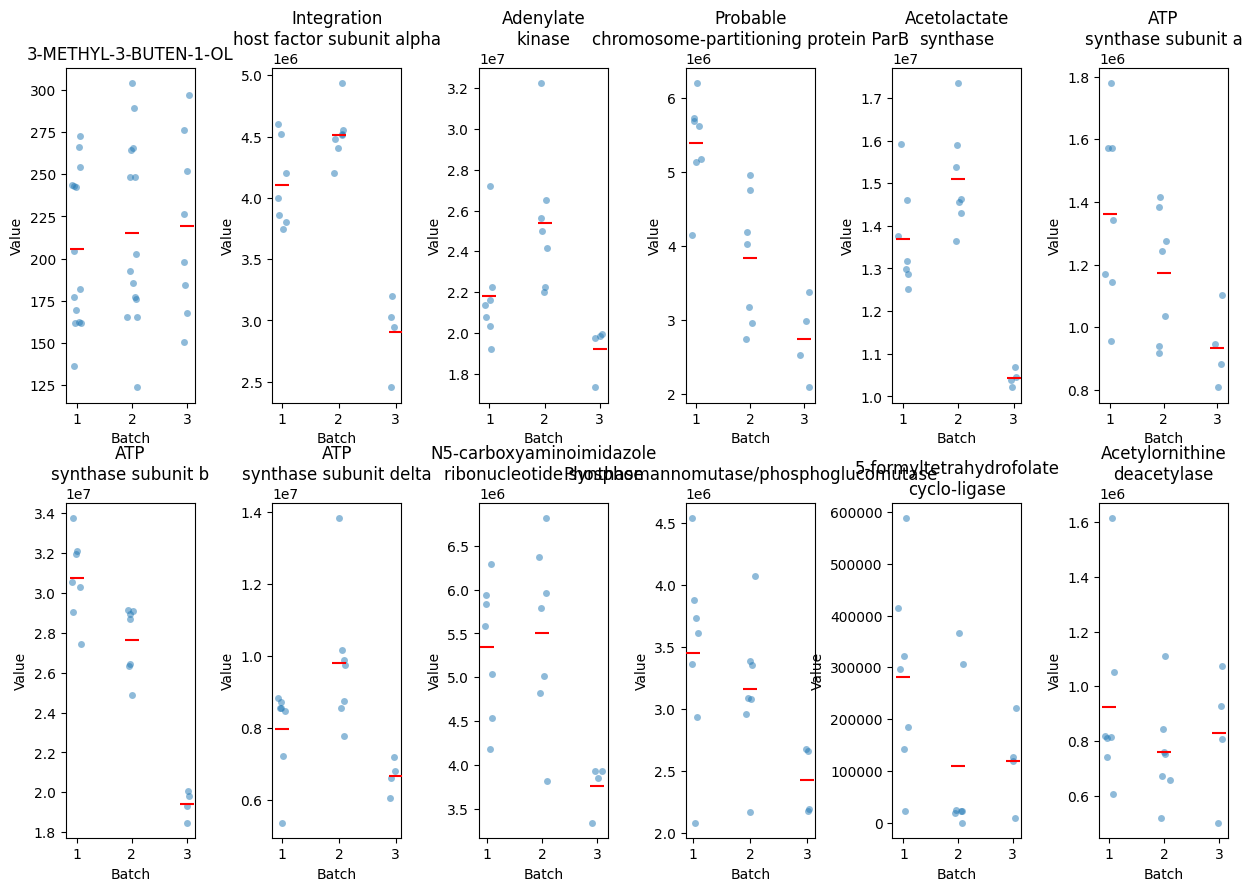

In [142]:
target_list_all = df2[df2['Control']]['Measurement Type'].unique().tolist()
control_swarm_fig = compare_swarm_multi(df2[df2['Control']], target_list_all[:12], [1,2,3])

#### 2.9.3 Distribution of differences
Calculating change in counts for (batch 3) - (batch 1) should skew negative for unnormalized data, but should go away with normalization.

Make pivot tables for normalized an unnormalized data and set up labels. 

In [143]:
proteomics_control_batch_means = pd.pivot_table(df2[df2['Control']], values = ['Value', 'norm_value'], columns = 'Batch', index = 'Measurement Type', aggfunc = np.mean)
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['Batch 3 - Batch 1',
              'Batch 2 - Batch 1']
proteomics_control_batch_means

Value  \
Batch                                                          1   
Measurement Type                                                   
3-METHYL-3-BUTEN-1-OL                               2.055672e+02   
3-hydroxy acid dehydrogenase, NADP-dependent / ...  4.523416e+06   
3-hydroxybutyryl-CoA dehydrogenase                  6.215039e+05   
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...  1.074932e+07   
3-ketoacyl-CoA thiolase                             3.633296e+06   
...                                                          ...   
Thiolase family protein                             7.354945e+04   
Ubiquinol oxidase subunit 2                         1.050896e+07   
Ubiquinol oxidase subunit I, cyanide insensitive    3.204960e+05   
Ubiquinol--cytochrome c reductase, cytochrome c1    6.465339e+06   
Ubiquinol-cytochrome c reductase iron-sulfur su...  7.060612e+06   

                                                                  \
Batch                                                          2   
Measurement Type                                                   
3-METHYL-3-BUTEN-1-OL                               2.149264e+02   
3-hydroxy acid dehydrogenase, NADP-dependent / ...  4.162383e+06   
3-hydroxybutyryl-CoA dehydrogenase                  5.696421e+05   
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...  9.631210e+06   
3-ketoacyl-CoA thiolase                             3.007574e+06   
...                                                          ...   
Thiolase family protein                             1.776669e+05   
Ubiquinol oxidase subunit 2                         8.298769e+06   
Ubiquinol oxidase subunit I, cyanide insensitive    1.209153e+05   
Ubiquinol--cytochrome c reductase, cytochrome c1    6.073736e+06   
Ubiquinol-cytochrome c reductase iron-sulfur su...  6.081083e+06   

                                                                  norm_value  \
Batch                                                          3           1   
Measurement Type                                                               
3-METHYL-3-BUTEN-1-OL                               2.190687e+02  205.567203   
3-hydroxy acid dehydrogenase, NADP-dependent / ...  3.047278e+06    1.000000   
3-hydroxybutyryl-CoA dehydrogenase                  3.762857e+05    1.000000   
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...  7.542387e+06    1.000000   
3-ketoacyl-CoA thiolase                             2.349939e+06    1.000000   
...                                                          ...         ...   
Thiolase family protein                             2.609343e+05    1.000000   
Ubiquinol oxidase subunit 2                         8.097839e+06    1.000000   
Ubiquinol oxidase subunit I, cyanide insensitive    3.448670e+05    1.000000   
Ubiquinol--cytochrome c reductase, cytochrome c1    4.071625e+06    1.000000   
Ubiquinol-cytochrome c reductase iron-sulfur su...  3.269404e+06    1.000000   

                                                                           
Batch                                                       2           3  
Measurement Type                                                           
3-METHYL-3-BUTEN-1-OL                               214.92644  219.068729  
3-hydroxy acid dehydrogenase, NADP-dependent / ...    1.00000    1.000000  
3-hydroxybutyryl-CoA dehydrogenase                    1.00000    1.000000  
3-hydroxydecanoyl-[acyl-carrier-protein] dehydr...    1.00000    1.000000  
3-ketoacyl-CoA thiolase                               1.00000    1.000000  
...                                                       ...         ...  
Thiolase family protein                               1.00000    1.000000  
Ubiquinol oxidase subunit 2                           1.00000    1.000000  
Ubiquinol oxidase subunit I, cyanide insensitive      1.00000    1.000000  
Ubiquinol--cytochrome c reductase, cytochrome c1      1.00000    1.000000  
Ubiquinol-cytochrome c reductase iron-sulfur

Make plots to show the distribution of differences. 

Text(0.5, 0.98, 'Non-normalized Control')

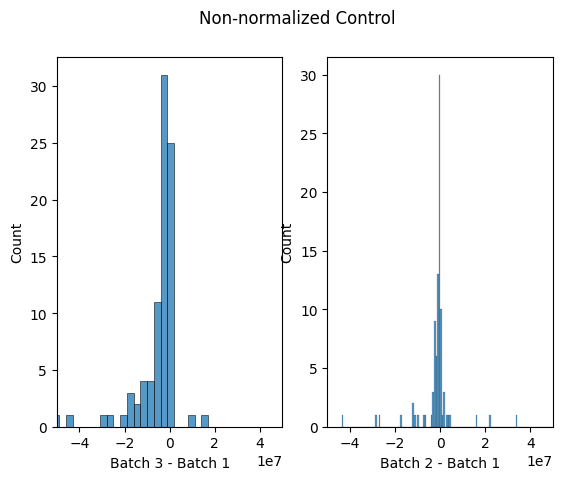

In [144]:
fig, ax = plot_distribution_of_differences(proteomics_control_batch_means['Value'], dif_to_plot, dif_labels)
ax_lim = 5e7
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
fig.suptitle('Non-normalized Control')

#### 2.9.4 Swarmplots for all proteins
These swarmplots compare the distribution of all proteins in each batch before and after normalization. We can see that the normalization makes the difference in distributions much less. 



Text(0.5, 0.98, 'Normalized Proteomics - all lines')

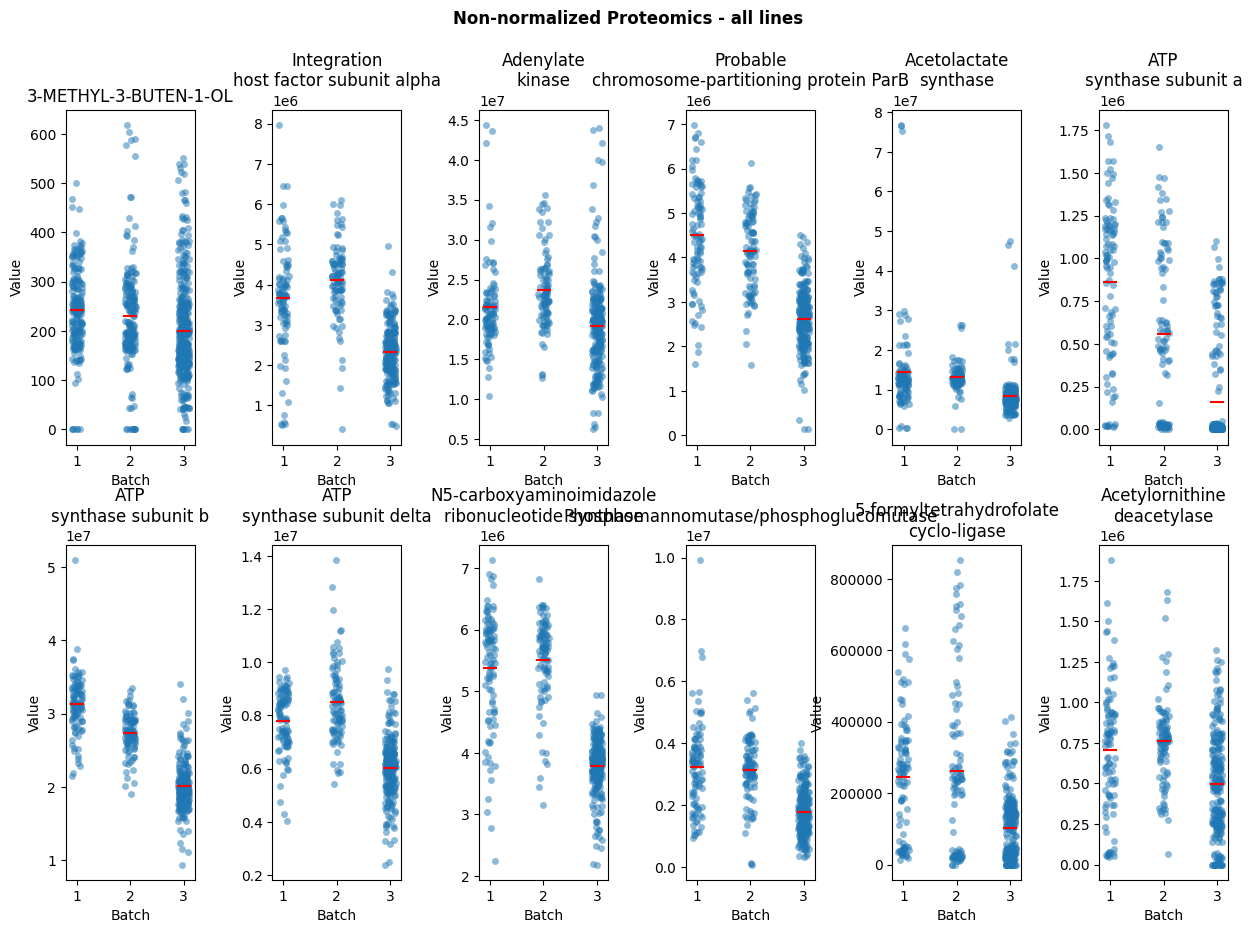

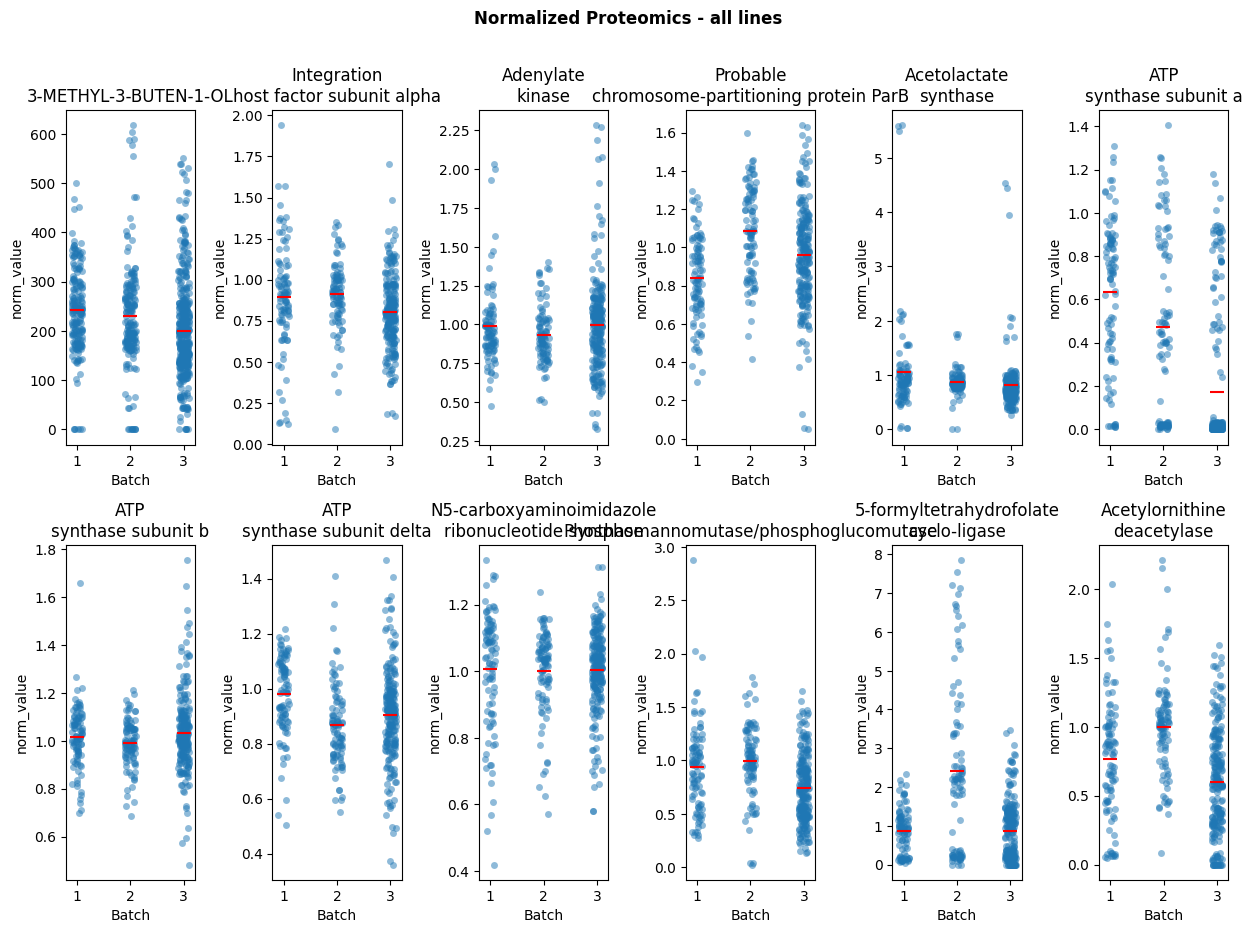

In [145]:
target_list_filter = df2['Measurement Type'].unique().tolist()
unnorm_fig = compare_swarm_multi(df2, target_list_filter[:12], [1,2,3], to_plot='Value')
unnorm_fig.suptitle('Non-normalized Proteomics - all lines', fontweight = 'bold')
norm_fig = compare_swarm_multi(df2, target_list_filter[:12], [1,2,3], to_plot='norm_value')
norm_fig.suptitle('Normalized Proteomics - all lines', fontweight = 'bold')

## 3. Statistical Analysis
### 3.1 Pivot dataframe to target table:

Pivot dataframe to table with strain as the row name, columns as the gene, and proteomics values as the value. Create one for normalized values and one for non-normalized values.

In [146]:
df_targets = df2.pivot_table(
    index = "Strain", columns = "Formal Type", values = "norm_value", aggfunc = np.mean)


Check values for control after normalization - should all be 1

Strains where controls are not one:[]
Test: Control strains normalized to 1 passed


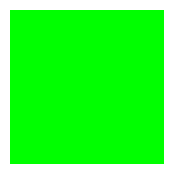

In [147]:
normed_controls = df_targets.loc['NT',:]
non_unity_strains = normed_controls[abs(normed_controls.values-1.00)>0.000001].index[:-1].values
print(f'Strains where controls are not one:{non_unity_strains}')
display_test_passage(len(non_unity_strains) == 0, 'Control strains normalized to 1')

In [148]:
df_targets.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988,dCas9
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,241.511759,0.025598
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,252.234862,0.654754
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,128.710472,0.474752
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,295.850667,0.944585
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,292.666583,0.706818


Change compound ID to Isoprenol

In [149]:
df_targets.rename(columns = {'cid:12988': 'Isoprenol mean'}, inplace = True)
df_targets.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,dCas9
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,241.511759,0.025598
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,252.234862,0.654754
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,128.710472,0.474752
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,295.850667,0.944585
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,292.666583,0.706818


Add the target genes to this table - create a map from the strains and targets in df2.

In [150]:
target_map = df2[['Strain', 'Target']].drop_duplicates().set_index("Strain")
target_map

,Target
Strain,
IY1586,PP_4549
IY1587,PP_4550
IY1588,PP_0368
IY1589,PP_2136
IY1590,PP_0774
...,...
IY2029,PP_4123
IY2032,PP_4128
IY2019,PP_5420


In [151]:
df_targets.loc[target_map.index, 'Target'] = target_map['Target']
df_targets

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,dCas9,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,241.511759,0.025598,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,252.234862,0.654754,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,128.710472,0.474752,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,295.850667,0.944585,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,292.666583,0.706818,PP_2136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IY2237,0.930909,1.096756,1.604689,0.970164,0.731419,1.448632,1.208867,0.449017,0.759670,1.362459,...,0.983111,0.597633,0.837866,1.074284,0.993945,1.092833,0.296326,165.803638,0.065246,PP_1023
IY2238,1.269479,1.746121,0.816886,0.938776,0.599624,1.124853,1.001651,0.116368,0.825061,3.355407,...,0.816654,0.654857,0.620207,1.102293,0.764975,0.941443,0.021652,133.956667,0.060199,PP_5128
IY2239,1.052155,1.322122,1.542706,0.822699,0.689241,1.479096,0.927091,0.770810,0.581115,0.779890,...,0.398636,0.817151,1.128423,1.057805,0.772609,0.966421,0.009078,164.819502,0.089107,PP_2095


Some target genes are not present in the proteomics data:

In [152]:
print('Genes missing from proteomics data:')
for gene, titer in zip(df_targets['Target'], df_targets['Isoprenol mean']):
    if gene not in df_targets.columns:
        print(f'gene: {gene}\ttiter: {titer}')

Genes missing from proteomics data:
gene: PP_0362	titer: 269.73688999999996
gene: PP_2589	titer: 239.63472166666668
gene: PP_3744	titer: 282.2509166666667
gene: PP_3394	titer: 0.0
gene: PP_3355	titer: 302.1513333333333
gene: PP_3282	titer: 197.1970266666667
gene: PP_1157	titer: 209.78477833333332
gene: PP_1394	titer: 213.3349166666667
gene: PP_3280	titer: 244.101305
gene: PP_4737	titer: 231.06377833333332
gene: PP_0548	titer: 381.1143333333334
gene: PP_5420	titer: 137.40613333333332
gene: PP_0806	titer: 265.09461166666665
gene: PP_4128	titer: 249.49306666666666
gene: PP_4043	titer: 175.38875
gene: PP_0103	titer: 229.4020833333333
gene: PP_0104	titer: 163.018445
gene: PP_0105	titer: 181.044055
gene: PP_0106	titer: 156.28922166666666
gene: PP_0814	titer: 390.49489
gene: PP_0815	titer: 323.72225
gene: PP_4161	titer: 152.467695
gene: PP_4160	titer: 155.56113833333333
gene: PP_4159	titer: 173.96381499999998
gene: PP_0277	titer: 158.32637166666666
gene: PP_4650	titer: 159.35707333333332
gene

### 3.2 Add Proteomics Stats

Now we can add the statistical data from the proteomics data (mean, std, first and third quantile):

In [153]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [154]:
df_targets = find_library_stats(df_targets)
df_targets.head()

Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,dCas9,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,241.511759,0.025598,PP_1607
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,252.234862,0.654754,PP_4549
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,128.710472,0.474752,PP_4550
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,295.850667,0.944585,PP_0368
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,292.666583,0.706818,PP_2136


### 3.3 Add Isoprenol production data

Find CV for isoprenol production.

Create dataframe for isoprenol production and sort

In [182]:
df_isoprenol             = df2[df2['Measurement Type']=='3-METHYL-3-BUTEN-1-OL']
df_isoprenol             = df_isoprenol.drop(columns=['Line Name', 'Line Description', 'Measurement Type', 'Protocol','Control', 'Batch', 'can_normalize', 'control_mean', 'norm_value', 'Formal Type'])
product = 'Isoprenol'
df_isoprenol.rename(columns={'Value': product}, inplace=True)
df_isoprenol = df_isoprenol.sort_values(product, ascending=False)
df_isoprenol

,Isoprenol,Strain,Target
149293,618.3056,IY2020,PP_5419
149263,603.9709,IY1688,PP_0528
149270,590.6272,IY1688,PP_0528
149281,587.8620,IY2020,PP_5419
149277,577.0506,IY1688,PP_0528
...,...,...,...
1182509,0.0000,IY1661,PP_3394
1182536,0.0000,IY2025,PP_4119
1182645,0.0000,IY2192,PP_5064
1182646,0.0000,IY2192,PP_5064


Extract statistics (standard deviation and %CV) on isoprenol production

In [184]:
df_isoprenol

,Isoprenol,Strain,Target
149293,618.3056,IY2020,PP_5419
149263,603.9709,IY1688,PP_0528
149270,590.6272,IY1688,PP_0528
149281,587.8620,IY2020,PP_5419
149277,577.0506,IY1688,PP_0528
...,...,...,...
1182509,0.0000,IY1661,PP_3394
1182536,0.0000,IY2025,PP_4119
1182645,0.0000,IY2192,PP_5064
1182646,0.0000,IY2192,PP_5064


In [186]:
stats_isoprenol          = df_isoprenol.groupby('Strain').mean(numeric_only=True)
stats_isoprenol.rename(columns={'Isoprenol': 'mean'}, inplace=True)
stats_isoprenol['std']   = df_isoprenol[['Strain', 'Isoprenol']].groupby(['Strain']).std()['Isoprenol']
stats_isoprenol['CV[%]'] = 100* stats_isoprenol['std'] / stats_isoprenol['mean']
stats_isoprenol = stats_isoprenol.sort_values('CV[%]', ascending=False)
stats_isoprenol.head()

,mean,std,CV[%]
Strain,,,
IY2192,13.208167,21.066922,159.499216
IY2025,27.581113,21.382796,77.526952
IY1671,134.117489,100.972986,75.286965
IY2195,52.886445,32.285179,61.046227
IY2057,179.755085,55.209573,30.713775


Add %CV to the isoprenol dataframe:

In [187]:
df_isoprenol['CV[%]'] = None
strains = [strain for strain in stats_isoprenol.index.unique()]
for strain in strains:
    index = df_isoprenol[df_isoprenol['Strain']==strain].index
    cv_value = stats_isoprenol[stats_isoprenol.index==strain]['CV[%]'].values
    df_isoprenol.loc[index, 'CV[%]'] = np.ones(len(index))*cv_value

df_isoprenol = df_isoprenol.set_index('Strain')
df_targets.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]

In [188]:
df_targets.head()

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,dCas9,Target,CV[%]
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,241.511759,0.025598,PP_1607,28.699152
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,252.234862,0.654754,PP_4549,21.938969
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,128.710472,0.474752,PP_4550,23.213085
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,295.850667,0.944585,PP_0368,22.221554
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,292.666583,0.706818,PP_2136,21.919476


## 4. Data Visualization
Visualize isoprenol production and CV. First, some useful functions.

Plot titer and %CV on same plot by strain.

In [227]:
def plot_titers(df_prod, df_control_stat, product='Isoprenol'):
    "Plots isprenols titers as well as CV"
        
    ## create figure
    fig, ax = plt.subplots(figsize=(20,5))
    sns.set_style('white')

    ## Plot production in salmon color
    g = sns.scatterplot(data=df_prod,
                        x = 'Strain',
                        y = product,
                        color = 'salmon',
                        )
    ## Format isoprenol axis
    # control_xval = np.where(df_prod.index.unique() == 'NT')
    control_xval = g.convert_xunits('NT')
    plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
                df_control_stat[product], 
                marker = 'o', 
                color = 'none', 
                edgecolor = 'k', 
                label = 'control')
    g.set_xticks(g.get_xticks())
    g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)

    ax.set_ylabel(product + " [uM]", fontsize=10, color='salmon')
    ax.set_xlabel("Strains", fontsize=10)
    
    ## Create %CV axis
    ax2 = plt.twinx()
    g2 = sns.scatterplot(data=df_prod,
                        x='Strain',
                        y='CV[%]', 
                        color='gray',
                        marker='o',
                        ax=ax2)
    plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],
                    marker='o', color="None",  edgecolor='k', label='Control'
                    )
    ax2.set_ylabel("CV[%]", fontsize=10, color='gray')
    sns.despine(left=True, bottom=True)
    ax.legend()
    ## Save figure
    fig.savefig(
        f"{user_params['output_dir']}/titer_cv.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

For a given protein, plot the distribution of protein measurements in the library, the value of that protein in the control, and the value of that protein in the CRISPRi strain targeting it.

In [190]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value'):
    
    # Figure dimensions, color and label
    fig_height = 25
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    df_crispr.sort_values('Isoprenol mean', ascending=False, inplace=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3, 
                    )

            # Add control
            sns.scatterplot(df_targets.loc[control_strain, target], '.', color='k', markersize=10)
            
            # Add target
            data = df_targets[df_targets['Target']==target][target]
            #if len(data)==1:
            sns.scatterplot(data, marker='_', color=color, markersize=50, markeredgewidth=3)
                
        sns.despine(left=False, bottom=True)
        if target == targetsP[0]:
            ax.legend()
    if save_name is None:
        save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
    if save:
        fig.savefig(
            save_name,
            transparent=True,
            bbox_inches="tight",
            dpi=300,
            )
    return fig

In [191]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value', fig_height = 15):
    
    # Figure dimensions, color and label
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    df_crispr.sort_values('Isoprenol mean', ascending=False, inplace=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3, 
                    label = 'Library distribution')

            # Add control
            plt.plot(df_targets.loc[control_strain, target], '.', color='k', markersize=10, label = 'Control')

            # Add target
            data = df_targets[df_targets['Target']==target][target]
            if len(data)==1:
                plt.plot(data, marker='_', color=color, markersize=20, markeredgewidth=3, label = 'Target')
            
        sns.despine(left=False, bottom=True)
        if target == targetsP[0]:
            plt.legend()
    if save_name is None:
        save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
    if save:
        fig.savefig(
            save_name,
            transparent=True,
            bbox_inches="tight",
            dpi=300,
            )
    return fig

### 4.1 Plot titers and %CV for all strains

In [192]:
control_strain = df2.loc[df2['Control']==True,:]['Strain'].unique()[0]
df_control_stat = df_isoprenol.loc[control_strain]

In [193]:
df_isoprenol

,Isoprenol,Target,CV[%]
Strain,,,
IY2020,618.3056,PP_5419,22.447678
IY1688,603.9709,PP_0528,22.007325
IY1688,590.6272,PP_0528,22.007325
IY2020,587.8620,PP_5419,22.447678
IY1688,577.0506,PP_0528,22.007325
...,...,...,...
IY1661,0.0000,PP_3394,NaN
IY2025,0.0000,PP_4119,77.526952
IY2192,0.0000,PP_5064,159.499216


In [224]:
df_isoprenol.loc['IY2020',:]

,Isoprenol,Target,CV[%]
Strain,,,
IY2020,618.30560,PP_5419,22.447678
IY2020,587.86200,PP_5419,22.447678
IY2020,555.37710,PP_5419,22.447678
IY2020,412.20373,PP_5419,22.447678
IY2020,391.90800,PP_5419,22.447678
IY2020,370.25140,PP_5419,22.447678


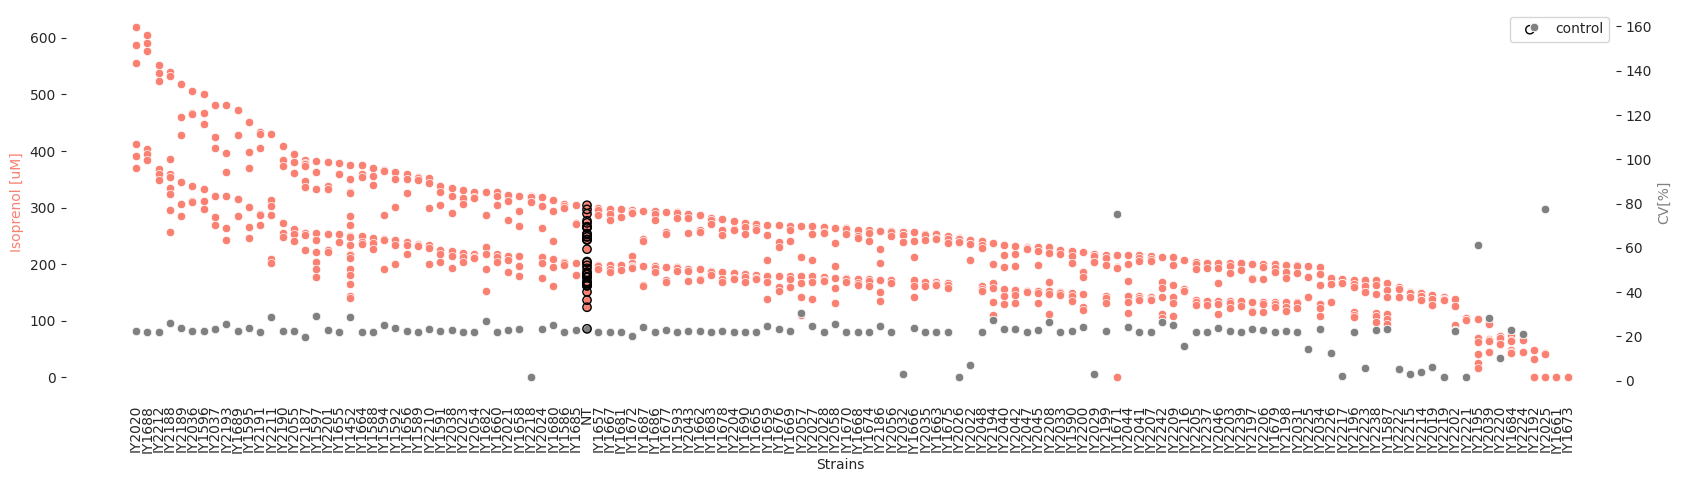

In [228]:
plot_titers(df_isoprenol, df_control_stat, 'Isoprenol')

### 4.2 Plot distribution of proteomics

Visualize distribution of proteomics levels in each strain (distributions) compared to the strain where that protein was targeted. 

['PP_0528', 'PP_5419', 'PP_4191', 'PP_4174', 'PP_0813', 'PP_4189', 'PP_1240', 'PP_1769', 'PP_0812', 'PP_0751', 'PP_1770', 'PP_0368', 'PP_2136', 'PP_1506', 'PP_4192', 'PP_0437', 'PP_4193', 'PP_5335', 'PP_0338', 'PP_4188']


Text(0.5, 0.98, 'Proteomic distributions of highest titers')

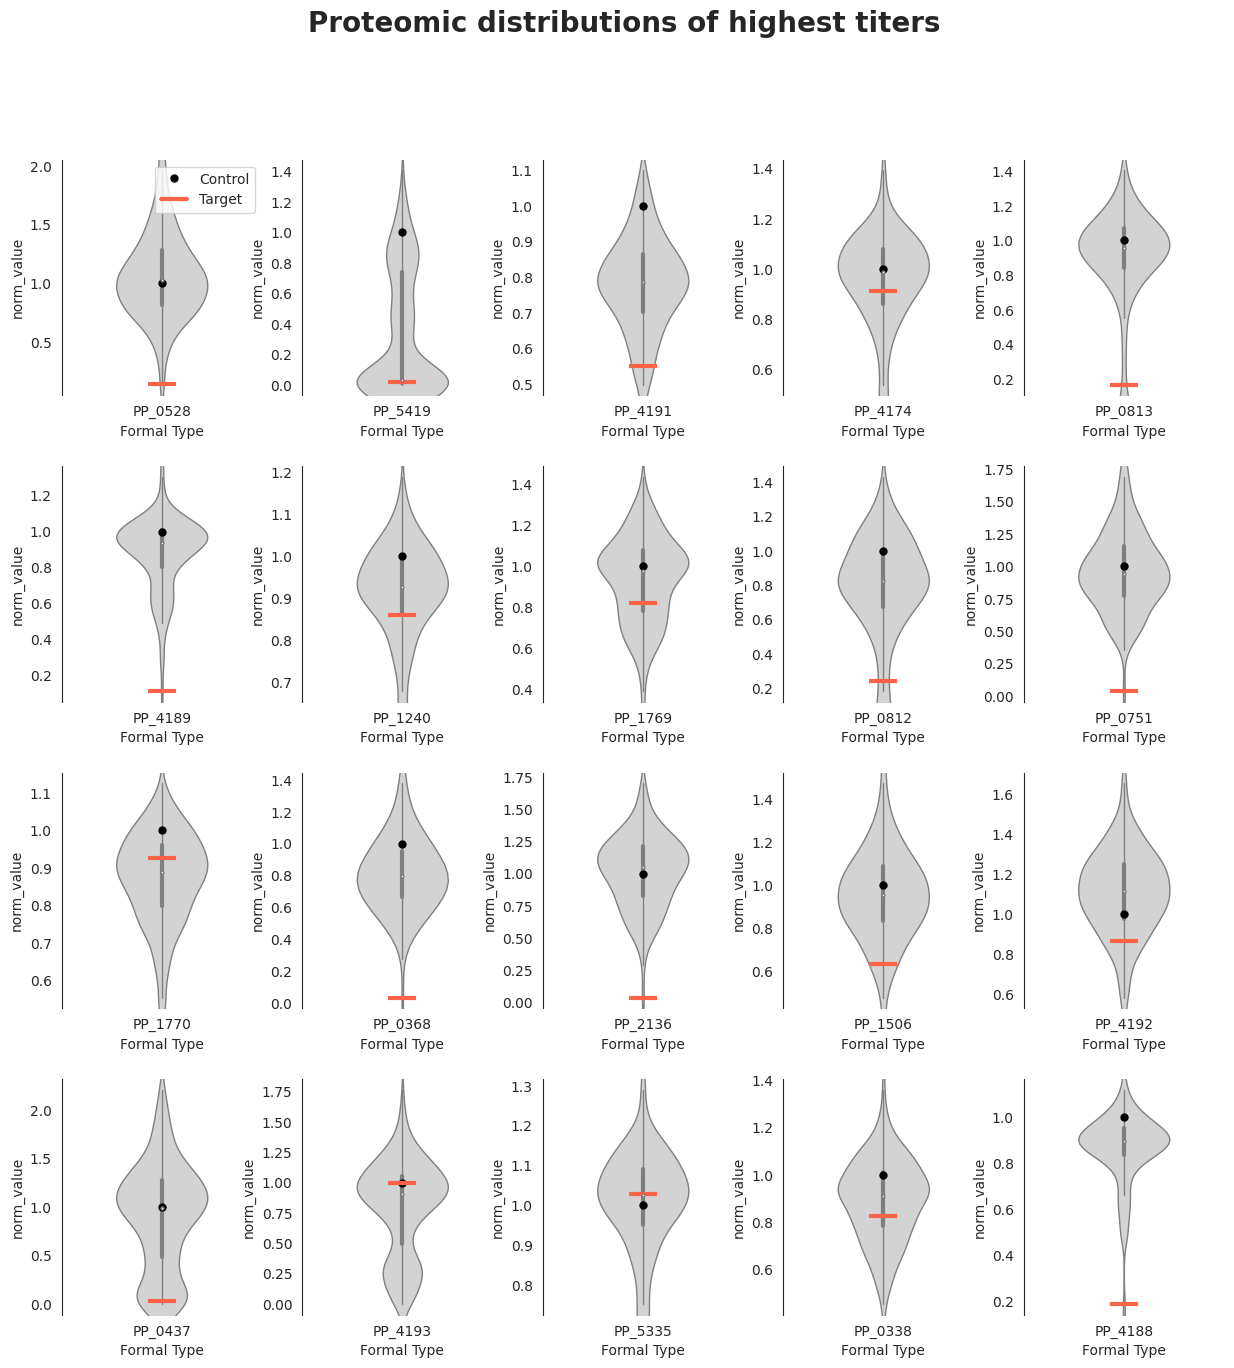

In [229]:
targets_all = list(df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:].sort_values('Isoprenol mean', ascending=False, inplace = False)['Target'].values)
targets_filter = []
for tt in targets_all:
    if (sum(df_targets['Target'] == tt) == 1) and (tt in df2['Formal Type'].unique()):
        targets_filter.append(tt)
targetsP = targets_filter[:20]
print(targetsP)
fig = plot_crispr_library(df2, df_targets, targetsP, save=False, violin_field='norm_value')
fig.suptitle('Proteomic distributions of highest titers', size = 20,  fontweight = 'bold')

In [231]:
df_targets

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,dCas9,Target,CV[%]
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,241.511759,0.025598,PP_1607,28.699152
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,252.234862,0.654754,PP_4549,21.938969
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,128.710472,0.474752,PP_4550,23.213085
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,295.850667,0.944585,PP_0368,22.221554
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,292.666583,0.706818,PP_2136,21.919476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,212.207245,1.000000,Control,23.44284
Library_mean,0.971413,1.392877,0.990227,0.896029,0.852300,0.913986,1.098607,0.718635,0.816521,3.369946,...,1.242292,0.851511,1.005283,0.903975,1.020761,0.321725,NaN,NaN,NaN,NaN
Library_std,0.184909,0.823098,0.652679,0.140861,0.372172,0.341719,0.278543,0.900159,0.330427,4.914288,...,0.952425,0.307893,0.100187,0.129127,0.121520,0.333621,NaN,NaN,NaN,NaN


### 4.3 Plot distribution of dCas9

#### 4.3.1 Make dataframe for dCas9 expression and target expression
Copy some columns from target_df

In [260]:
df_cas = df_targets[['dCas9', 'Target', 'Isoprenol mean']]
df_cas = df_cas.iloc[:-4,:]
df_cas

Formal Type,dCas9,Target,Isoprenol mean
Strain,,,
IY1452,0.025598,PP_1607,241.511759
IY1586,0.654754,PP_4549,252.234862
IY1587,0.474752,PP_4550,128.710472
IY1588,0.944585,PP_0368,295.850667
IY1589,0.706818,PP_2136,292.666583
...,...,...,...
IY2237,0.065246,PP_1023,165.803638
IY2238,0.060199,PP_5128,133.956667
IY2239,0.089107,PP_2095,164.819502


Drop any strains where the protein isn't measured

In [261]:
check_target_proteomics_exists = lambda x: np.any(df_targets.columns == x)
df_cas['has_proteomics'] = df_cas['Target'].apply(check_target_proteomics_exists)
df_cas

Formal Type,dCas9,Target,Isoprenol mean,has_proteomics
Strain,,,,
IY1452,0.025598,PP_1607,241.511759,True
IY1586,0.654754,PP_4549,252.234862,True
IY1587,0.474752,PP_4550,128.710472,True
IY1588,0.944585,PP_0368,295.850667,True
IY1589,0.706818,PP_2136,292.666583,True
...,...,...,...,...
IY2237,0.065246,PP_1023,165.803638,True
IY2238,0.060199,PP_5128,133.956667,True
IY2239,0.089107,PP_2095,164.819502,True


In [262]:
df_cas = df_cas[df_cas['has_proteomics']]
df_cas

Formal Type,dCas9,Target,Isoprenol mean,has_proteomics
Strain,,,,
IY1452,0.025598,PP_1607,241.511759,True
IY1586,0.654754,PP_4549,252.234862,True
IY1587,0.474752,PP_4550,128.710472,True
IY1588,0.944585,PP_0368,295.850667,True
IY1589,0.706818,PP_2136,292.666583,True
...,...,...,...,...
IY2225,0.237451,PP_4185,172.424043,True
IY2226,0.026384,PP_4186,158.079290,True
IY2237,0.065246,PP_1023,165.803638,True


In [263]:
df_cas = df_cas.reset_index()
df_cas

Formal Type,Strain,dCas9,Target,Isoprenol mean,has_proteomics
0,IY1452,0.025598,PP_1607,241.511759,True
1,IY1586,0.654754,PP_4549,252.234862,True
2,IY1587,0.474752,PP_4550,128.710472,True
3,IY1588,0.944585,PP_0368,295.850667,True
4,IY1589,0.706818,PP_2136,292.666583,True
...,...,...,...,...,...
95,IY2225,0.237451,PP_4185,172.424043,True
96,IY2226,0.026384,PP_4186,158.079290,True
97,IY2237,0.065246,PP_1023,165.803638,True
98,IY2238,0.060199,PP_5128,133.956667,True


Make function to get target correct target expression for each strain

In [264]:
get_target_expression = lambda x: df_targets.loc[x['Strain'], x['Target']]

In [265]:
df_cas['target_expr'] = df_cas.apply(get_target_expression, axis = 1)

In [266]:
df_cas

Formal Type,Strain,dCas9,Target,Isoprenol mean,has_proteomics,target_expr
0,IY1452,0.025598,PP_1607,241.511759,True,0.835546
1,IY1586,0.654754,PP_4549,252.234862,True,0.051375
2,IY1587,0.474752,PP_4550,128.710472,True,0.585066
3,IY1588,0.944585,PP_0368,295.850667,True,0.032587
4,IY1589,0.706818,PP_2136,292.666583,True,0.036127
...,...,...,...,...,...,...
95,IY2225,0.237451,PP_4185,172.424043,True,0.441776
96,IY2226,0.026384,PP_4186,158.079290,True,0.565147
97,IY2237,0.065246,PP_1023,165.803638,True,0.897604
98,IY2238,0.060199,PP_5128,133.956667,True,0.996786


(0.0, 1.5)

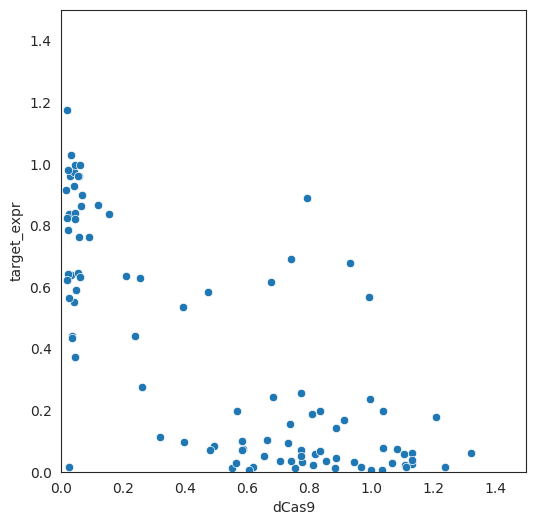

In [268]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(df_cas, x = 'dCas9', y = 'target_expr')
ax.set_xlim([0, 1.5])
ax.set_ylim([0, 1.5])

## 5. Make Recommendations - Selecting Target Genes
Criteria for downselection:

Transcription value for the CRISPRi targeted gene:

- Within the bottom 25th percentile of the library
- Less than 0.9 of the mean proteomics measurements in the library
- Isoprenol > 100

Define functions:

### 5.1 Quantify CRISPRi performance

We calculate the ratios of the target protein concentration to the control, library mean, Q1 and Q3 (eliminating the strain with the target gene):

In [269]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

In [270]:
df_targets = find_fold_changes(df_targets)
df_targets

Data for these 28 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_0548', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'PP_4650', 'PP_0225', 'Control']


Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,PP_5419,Isoprenol mean,dCas9,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,0.600624,241.511759,0.025598,PP_1607,28.699152,0.835546,0.895268,0.950706,0.837033,-0.859869
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,0.346177,252.234862,0.654754,PP_4549,21.938969,0.051375,0.073656,0.08812,0.062872,-3.694537
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,0.162470,128.710472,0.474752,PP_4550,23.213085,0.585066,0.232314,0.750753,0.226879,-0.387519
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,0.854964,295.850667,0.944585,PP_0368,22.221554,0.032587,0.038234,0.04758,0.035231,-2.202514
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,0.711793,292.666583,0.706818,PP_2136,21.919476,0.036127,0.03451,0.040185,0.031508,-3.533457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,212.207245,1.000000,Control,23.44284,None,None,None,None,None
Library_mean,0.971413,1.392877,0.990227,0.896029,0.852300,0.913986,1.098607,0.718635,0.816521,3.369946,...,0.321725,NaN,NaN,NaN,NaN,None,None,None,None,None
Library_std,0.184909,0.823098,0.652679,0.140861,0.372172,0.341719,0.278543,0.900159,0.330427,4.914288,...,0.333621,NaN,NaN,NaN,NaN,None,None,None,None,None


### 5.2 Filter strains

In [271]:
cols = [
    'Target',
    'Isoprenol mean','CV[%]',
    'Target:Control','Target:Library_mean',
    'Target:Library_Q1','Target:Library_Q3'
]
mean_thresh = 0.9
q1_thresh = 1
df_targets['to_keep'] = np.nan
df_targets['to_keep'] = df_targets['to_keep'].astype('boolean')

df_targets.loc[strains, 'to_keep'] = (df_targets.loc[strains, 'Target:Library_mean'] < mean_thresh) & \
                                    (df_targets.loc[strains, 'Isoprenol mean'] > 100) & \
                                    (df_targets.loc[strains, 'Target:Library_Q1'] < q1_thresh)
print(sum(df_targets.loc[strains,'to_keep']))                                           

66


Drop lines that didn't perform. 

### 5.3 Plot results of filtering
Define function to plot

In [273]:
def plot_filter_results(df_filter, horiz_thresh, vert_thresh, x_fields):
    #drop any NaNs left in df_targets['to_keep'] df = df[df['EPS'].notna()]

    df_filter = df_filter[df_filter['to_keep'].notna()]
    n_plots = len(x_fields)
    fig,ax = plt.subplots(1,n_plots, figsize = (15,5))
    
    for ii in range(n_plots):
        sns.scatterplot(df_filter, x = x_fields[ii], y = 'Isoprenol mean', hue = 'to_keep', ax = ax[ii])
        ax[ii].set_xlim([0, 2])
        ax[ii].axvline(vert_thresh[ii], color = 'k')
        ax[ii].axhline(horiz_thresh[ii], color = 'k')
    return fig

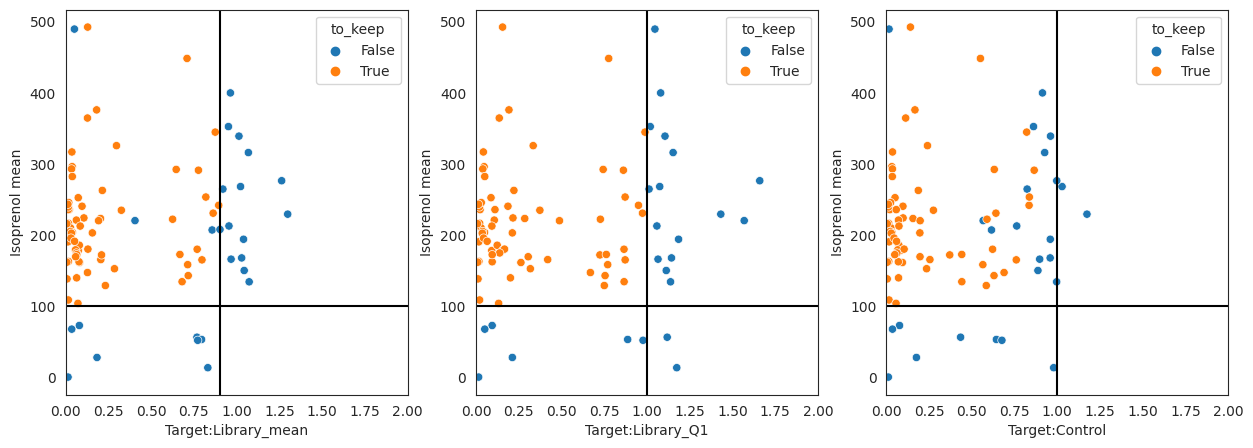

In [274]:
f = plot_filter_results(df_targets, 
                        [100, 100, 100], [mean_thresh, q1_thresh, 1],
                        ['Target:Library_mean', 'Target:Library_Q1', 'Target:Control'])
# f.savefig(f"{user_params['output_dir']}/target_filter_results.png",
#           transparent = True,
#           bbox_inches = 'tight',
#           dpi = 300,
#          )


In [275]:
gene_targets= df_targets[df_targets['to_keep']]['Target'].tolist()
print(str(len(gene_targets))+ " gene targets:")
print(gene_targets)
print(f'Max isoprenol in df selection {max(df_targets[df_targets["to_keep"]]["Isoprenol mean"])}')

66 gene targets:
['PP_1607', 'PP_4549', 'PP_4550', 'PP_0368', 'PP_2136', 'PP_0774', 'PP_0437', 'PP_1444', 'PP_3071', 'PP_3754', 'PP_3755', 'PP_3365', 'PP_4679', 'PP_4678', 'PP_3578', 'PP_5288', 'PP_0597', 'PP_4667', 'PP_3123', 'PP_2137', 'PP_2471', 'PP_2213', 'PP_4487', 'PP_0528', 'PP_4636', 'PP_5417', 'PP_0168', 'PP_4120', 'PP_4121', 'PP_4122', 'PP_4123', 'PP_0999', 'PP_4189', 'PP_4188', 'PP_4116', 'PP_4862', 'PP_1317', 'PP_1318', 'PP_4187', 'PP_1319', 'PP_0812', 'PP_0813', 'PP_1769', 'PP_5186', 'PP_0658', 'PP_1506', 'PP_1620', 'PP_4266', 'PP_1457', 'PP_5203', 'PP_0226', 'PP_4651', 'PP_4192', 'PP_4191', 'PP_0897', 'PP_0944', 'PP_1755', 'PP_0654', 'PP_0751', 'PP_2925', 'PP_2112', 'PP_2339', 'PP_4011', 'PP_4185', 'PP_4186', 'PP_2095']
Max isoprenol in df selection 492.12464


### 5.4 Add manually curated targets to target list
There are some targets with high titers but protein abundance below the proteomics limit of detection (PP_0814 and PP_0815). 

In [276]:
user_added_targets = ['PP_0812', 'PP_0813','PP_0814', 'PP_0815', 'PP_4188', 'PP_4189']
df_targets.loc[df_targets['Target'].isin(user_added_targets),'to_keep'] = True

#### 5.4.1 Add targets to dCas9 dataframe

In [277]:
df_targets

Formal Type,PP_0001,PP_0168,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0582,PP_0597,PP_0654,...,Isoprenol mean,dCas9,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score,to_keep
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,0.972544,0.598629,0.842324,0.933497,0.620934,1.081068,1.299539,0.478564,4.413050,...,241.511759,0.025598,PP_1607,28.699152,0.835546,0.895268,0.950706,0.837033,-0.859869,True
IY1586,0.918049,1.305330,1.297028,0.876275,0.834709,1.151605,1.159695,1.046509,0.802560,5.248360,...,252.234862,0.654754,PP_4549,21.938969,0.051375,0.073656,0.08812,0.062872,-3.694537,True
IY1587,0.628591,0.637950,0.630554,0.766956,0.708363,0.840861,0.922574,0.582428,0.920302,1.777312,...,128.710472,0.474752,PP_4550,23.213085,0.585066,0.232314,0.750753,0.226879,-0.387519,True
IY1588,0.702731,1.628167,2.243601,1.175192,0.032587,0.994764,1.060118,0.876955,0.765457,3.819998,...,295.850667,0.944585,PP_0368,22.221554,0.032587,0.038234,0.04758,0.035231,-2.202514,True
IY1589,0.958952,0.730286,0.738180,0.817158,3.959528,0.920269,1.251501,0.315354,0.682661,0.962319,...,292.666583,0.706818,PP_2136,21.919476,0.036127,0.03451,0.040185,0.031508,-3.533457,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,212.207245,1.000000,Control,23.44284,None,None,None,None,None,False
Library_mean,0.971413,1.392877,0.990227,0.896029,0.852300,0.913986,1.098607,0.718635,0.816521,3.369946,...,NaN,NaN,NaN,NaN,None,None,None,None,None,<NA>
Library_std,0.184909,0.823098,0.652679,0.140861,0.372172,0.341719,0.278543,0.900159,0.330427,4.914288,...,NaN,NaN,NaN,NaN,None,None,None,None,None,<NA>


In [278]:
df_cas

Formal Type,Strain,dCas9,Target,Isoprenol mean,has_proteomics,target_expr
0,IY1452,0.025598,PP_1607,241.511759,True,0.835546
1,IY1586,0.654754,PP_4549,252.234862,True,0.051375
2,IY1587,0.474752,PP_4550,128.710472,True,0.585066
3,IY1588,0.944585,PP_0368,295.850667,True,0.032587
4,IY1589,0.706818,PP_2136,292.666583,True,0.036127
...,...,...,...,...,...,...
95,IY2225,0.237451,PP_4185,172.424043,True,0.441776
96,IY2226,0.026384,PP_4186,158.079290,True,0.565147
97,IY2237,0.065246,PP_1023,165.803638,True,0.897604
98,IY2238,0.060199,PP_5128,133.956667,True,0.996786


In [282]:
check_target_filter = lambda x: 'pass' if df_targets.loc[x, 'to_keep'] else 'fail'
check_target_useradded = lambda x: 'user'

In [290]:
user_added_targets

['PP_0812', 'PP_0813', 'PP_0814', 'PP_0815', 'PP_4188', 'PP_4189']

user_added_targets

In [292]:
def check_target_filter(x):
    if x['Target'] in user_added_targets:
        return 'user_added'
    if df_targets.loc[x['Strain'], 'to_keep']:
        return 'passed_filter'
    else:
        return 'failed_filter'

In [293]:
df_cas['to_keep'] = df_cas.apply(check_target_filter, axis = 1)

(0.0, 1.5)

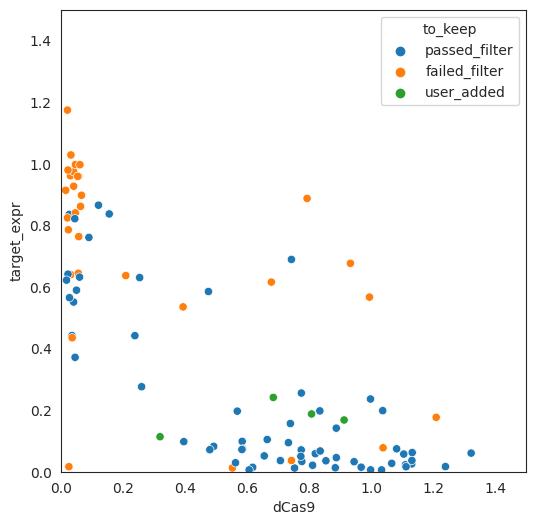

In [294]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(df_cas, x = 'dCas9', y = 'target_expr', hue = 'to_keep')
ax.set_xlim([0, 1.5])
ax.set_ylim([0, 1.5])

### 5.5 Weight possible targets by titer for selection
We will pseudorandomly select targets from the potential target list weighting by their relative titer. 

In [ ]:
df_targets_only = df_targets[df_targets['to_keep']][['Target', 'Isoprenol mean']]
df_targets_only.columns.name=''
display(df_targets_only)

In [ ]:
control_production = df_targets.loc["NT",'Isoprenol mean']
df_targets_only.loc[:,'Ratio'] = df_targets_only.loc[:,'Isoprenol mean']/control_production
df_targets_only

As ratios go from very close to zero to around 1, we will add a factor (e.g. 5) to all of the targets so to have a non-zero probability to sample each of the targets.

In [ ]:
df_targets_only['Weight']= 5 + (10*df_targets_only['Ratio']).apply(round)
df_targets_only = df_targets_only.astype({'Weight': 'int'})
df_targets_only

And we get rid of the ratio, since we use the weight column to choose doubles and triples:

In [ ]:
df_targets_only = df_targets_only[['Target', 'Isoprenol mean','Weight']]
n_targets = len(df_targets_only['Target'])
df_targets_only.head()

### 5.6 Functions for choosing targets

In [ ]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):
    "Choose recommended double and triple targets for CRISPRi knockdown"

    targets_list = list(df_targets['Target'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = tuple(sorted(random.sample(
            targets_list, counts=weights, k=size
        ))) # random sampling without replacement
        # new_target = sorted(random.choices(targets_list, weights=weights, k=size))
        # Check that the targets are not the same (sample function could provide repeated targets)
        # and if the combination was already chosen
        if len(set(new_target)) == size and new_target not in targets:
            targets.add(new_target)
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [ ]:
 def plot_double_targets(targets_double, df_targets):
    "Plot double targets chosen with the function above"    
        
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Target'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [ ]:
 def plot_triple_targets(targets_triple, df_targets):
    "Plot triple targets chosen with the function above"    
   
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Target']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

### 5.7 Check correlation between titer and selection rate

Select a bunch of single targets (so that repeats don't affect picks) and plot their occurence vs. titer.

In [ ]:
def plot_targets_vs_titer(df_targets):
    #Generate single targets
    targets_test = []
    for ii in range(1000):
        target_test = choose_targets(df_targets, size = 1, weighting = True, n_instances = 1)
        targets_test.append(target_test[0][0])
        
    df_test = df_targets.copy()
    df_test['n_selection'] = 0
    count_occurences = lambda x: targets_test.count(x)
    df_test['n_selection'] = df_test['Target'].apply(count_occurences)
    
    # Plotting
    fig, ax = plt.subplots(1,1)
    sns.scatterplot(df_test, x = 'Isoprenol mean', y = 'n_selection', ax = ax)
    plt.title('Correlation between random selections and titer')

In [ ]:
plot_targets_vs_titer(df_targets_only)

### 5.8 Choose double targets

We now choose double targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [ ]:
targets_double = choose_targets(
    df_targets_only, 
    size=2, 
    n_instances= user_params['n_instances_double'],
    verbose=1
)

for target in targets_double:
    print(target)
    
#Save to file: 
with open(user_params['double_targets_file'], mode="wt") as f:
    for target in targets_double:
        for indiv_gene in target:
            f.write(f'{indiv_gene}\t')
        f.write('\n')
        
plot_double_targets(targets_double, df_targets_only)


### 5.9 Choose triple targets

As for the case of double targets, we choose triple targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [ ]:
targets_triple = choose_targets(
    df_targets_only, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
)

print(targets_triple)

plot_triple_targets(targets_triple, df_targets_only)

with open(user_params['triple_targets_file'], mode="wt") as f:
    for target in targets_triple:
        for indiv_gene in target:
            f.write(f'{indiv_gene}\t')
        f.write('\n')

## 6. Visualize recommendations:
Make violin plots of the most common recommendations and all of the potential recommendations.


In [ ]:
sorted_filtered_targets = df_targets_only.loc[:, ['Isoprenol mean', 'Target']].dropna().sort_values('Isoprenol mean', ascending = False)
high_producers = list(sorted_filtered_targets.loc[:, 'Target'].values)
#Alter the save_name so that we don't overwrite the other image
save_name_highprod = f"{user_params['output_dir']}/crispri_high_producers.png"
high_prod_fig = plot_crispr_library(df2, df_targets, high_producers, save = True, violin_field = 'norm_value', save_name = save_name_highprod, fig_height = 40)
high_prod_fig.suptitle('Proteomics distributions ordered by titer', size = 20, fontweight = 'bold', y = 0.9)